<!-- # IMPORTS -->

<!-- Por incompatibilidades entre librerias nos vemos obligados a hacer este workaround para que solucionar los problemas de dependencias. -->

In [1]:
import  scipy.signal.signaltools
import numpy as np

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered
import pandas as pd
import matplotlib.pyplot as plt
# import os
# import pickle
import pytorch_forecasting
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
import torch
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, MAPE, MASE
from lightning.pytorch.tuner import Tuner
from scipy.ndimage import gaussian_filter1d
from  scipy.signal.signaltools import _centered
from tft_helper import *

import os
import sys

torch.backends.cudnn.benchmark = True # Enables cuDNN auto-tuner for faster runtime when input sizes are consistent

basepath = os.path.abspath("")  # script directory

sys.path.insert(1, os.path.join(basepath, "..\\"))
from datetime import datetime, timedelta

c:\Users\nicov\anaconda3\envs\tft\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


<!-- # PARAMS -->

In [2]:
target_file = 'BTC'
exog_files = ['Nasdaq', 'IBEX35', 'EUStoxx50', 'DowJones', 'S&P500', 'USD_EUR', 'GBP_USD', 'USTech100', 'S&P500Futures']

In [3]:
seq_len = 5 #sequence lenght: how many timesteps does a sequence have. For example a week could be considered a single sequence, therefore seq_len would be 5 as as the stock market opens 5 days a week.
pred_len = 25 # prediction lenght: How many timesteps does a prediction sequence have. For example if each prediction is a full week pred_len should be 5 as the stock market opens 5 days a week.
n_prev_len = 50 # Number of previous timesteps to take for inference. 
n_preds = 4 # number of predictions with test data
test_len = pred_len * n_preds  # Number of timesteps to use for test data.
group = "group" # If a same model should predict different stores, indices etc specify how to group them. If theres only one time series the set group col to one full of the same value.
loss = MAE() #QuantileLoss() # Loss function. 
epochs = 100 # Epochs to train the model.

# Set ts date range
date_start = '2010-01-04' #None #"2023-06-01"
date_end = "2024-7-29"
shift = 1 # How many times to shift values. Useful for using last indicator values (RSI, MACD...) for inference
ts_indicator_params = {
    "moving_average_windows": [5, 10, 20, 50, 100, 200], # Moving averages periods
    # "sigma_gaussian_filter": [1,2],
    "n_lags": 10,
                     
                     }
shift_cols = False
# cols_to_shift = [2:]

# Set training config.
lr_finder = False
grid_search = "random"
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
# logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

# TFT training params.
tft_params =  {"gradient_clip_val": 0.03, "hidden_size": 24, "dropout": 0.25, "hidden_continuous_size": 24, "attention_head_size": 4, "learning_rate": 0.01, "loss": loss, "early_stop_callback": early_stop_callback}


PIB_relevant_countries = ['USA',
 'CHN',
#  'EMU',
 'DEU',
#  'FRA',
#  'GBR',
 'JPN',
 'IND',
 'BRA',
 'CAN',
#  'AUS',
#  'ITA',
#  'KOR',
#  'MEX',
#  'IDN',
#  'SAU',
#  'ZAF',
#  'TUR',
#  'ESP'
 ]

# param_grid = {
#     "gradient_clip_val": [0.01, 0.03, 0.05],
#     "hidden_size": [8, 16, 32],
#     "dropout": [0.1, 0.25, 0.4],
#     "hidden_continuous_size": [8, 16, 32],
#     "attention_head_size": [2, 4, 8],
#     "learning_rate": [0.005, 0.01, 0.03],
#     "loss": [loss],
#     "test_len": [test_len],
#     "pred_len": [pred_len],
#     "n_prev_len": [n_prev_len],
# }

param_grid = {
    "gradient_clip_val": [0.01, 0.03, 0.05],
    "hidden_size": [8, 16, 32],
    "dropout": [0.1, 0.2, 0.3],
    "hidden_continuous_size": [16, 64, 128],
    "attention_head_size": [4,8,16],
    "learning_rate": [0.005, 0.01, 0.03],
    "loss": [loss],
    "test_len": [test_len],
    "pred_len": [pred_len],
    "n_prev_len": [n_prev_len],
}

<!-- # LOAD DATA -->

In [4]:
df = create_combined_ts_df(target_file, exog_files)
df

Dataset does not contain volume data.
Dataset does not contain volume data.
Dataset does not contain volume data.
Dataset does not contain volume data.
Dataset does not contain volume data.


,Date,target,open,max,min,var,exog_Nasdaq,exog_IBEX35,exog_EUStoxx50,exog_DowJones,exog_S&P500,exog_USD_EUR,exog_GBP_USD,exog_USTech100,exog_S&P500Futures
0,2016-01-01,434.0,430.0,438.0,425.9,0.94,NaN,NaN,NaN,NaN,NaN,0.9208,1.4748,NaN,NaN
1,2016-01-02,433.7,434.0,437.4,430.7,-0.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-03,430.7,433.7,434.1,423.1,-0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-04,433.3,430.7,435.3,428.6,0.61,4497.86,9313.2,3164.76,17148.94,2012.7,0.9232,1.4718,4497.9,2009.00
4,2016-01-05,431.2,433.3,435.3,428.9,-0.49,4484.18,9335.2,3178.01,17158.66,2016.7,0.9304,1.4672,4484.2,2011.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3246,2024-11-20,94303.9,92252.6,94836.1,91517.4,2.24,NaN,NaN,NaN,43225.79,NaN,0.9483,1.2650,20664.8,5937.75
3247,2024-11-21,98374.5,94308.7,98937.2,94063.8,4.32,NaN,NaN,NaN,NaN,NaN,0.9546,1.2586,20695.6,5970.50
3248,2024-11-22,98929.7,98381.2,99617.4,97182.2,0.56,NaN,NaN,NaN,NaN,NaN,0.9595,1.2531,20800.4,5987.00
3249,2024-11-23,97699.0,98927.2,98927.2,97180.9,-1.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<!-- ## ADD INDICATORS -->


In [5]:
df = add_global_indicators(df, PIB_relevant_countries, date_start, date_end)
df = add_indicators(df, ts_indicator_params, categorical_tendency_vars=True)
# df = df.rename(columns={"target": "exog_target"})
# df = df.rename(columns={"target_smoothed_2": "target"})


In [6]:
df

,Date,target,open,max,min,var,exog_Nasdaq,exog_IBEX35,exog_EUStoxx50,exog_DowJones,...,bullish_rsi,bearish_rsi,bullish_bollinger,bearish_bollinger,bullish_macd,bearish_macd,bullish_atr,bearish_atr,bullish_trend,bearish_trend
0,2016-01-01,434.0,430.0,438.0,425.9,0.94,4497.86,9313.2,3164.76,17148.94,...,0,0,0,0,0,0,0,0,0,0
1,2016-01-02,433.7,434.0,437.4,430.7,-0.06,4497.86,9313.2,3164.76,17148.94,...,0,0,0,0,0,1,0,0,0,0
2,2016-01-03,430.7,433.7,434.1,423.1,-0.70,4497.86,9313.2,3164.76,17148.94,...,0,0,0,0,0,1,0,0,0,0
3,2016-01-04,433.3,430.7,435.3,428.6,0.61,4497.86,9313.2,3164.76,17148.94,...,0,0,0,0,0,1,0,0,0,0
4,2016-01-05,431.2,433.3,435.3,428.9,-0.49,4484.18,9335.2,3178.01,17158.66,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3128,2024-07-25,65799.3,65363.9,66088.6,63500.9,0.66,18830.59,11145.6,4811.28,39935.07,...,0,1,0,0,1,0,0,1,0,0
3129,2024-07-26,67908.6,65799.7,68205.0,65764.3,3.21,19023.66,11165.9,4862.50,40589.34,...,0,1,0,0,1,0,1,0,1,0
3130,2024-07-27,67843.1,67910.8,69387.6,66776.8,-0.10,19023.66,11165.9,4862.50,40589.34,...,0,1,0,0,1,0,0,1,0,0
3131,2024-07-28,68256.3,67888.9,68291.9,67067.8,0.61,19023.66,11165.9,4862.50,40589.34,...,0,1,0,0,1,0,0,1,0,0


In [ ]:
# # SHift indicator values
# if shift_cols:
#     cols_to_shift = [col for col in df.columns[3:] if not (col.startswith('AAII') or col.startswith('PIB'))]
#     df[cols_to_shift] = df[cols_to_shift].shift(shift)


In [8]:
data = df.copy().dropna()
data.rename(columns={'target': 'close'}, inplace=True)
data.to_csv('BTC.csv', index=False)

In [9]:
evvcw

NameError: name 'evvcw' is not defined

In [ ]:
data = df.copy()
data["group"] = 1

# Supongamos que tu DataFrame se llama 'data' y que la columna 'Date' tiene las fechas
# Crear una lista de días festivos (ejemplo, agrega tus días festivos)
dias_festivos = pd.to_datetime(["2024-01-01", "2024-12-25", ])  # Añade más días festivos

# Meses del año (convertir a nombres de meses)
data["month"] = data["Date"].dt.strftime('%B')  # Ejemplo: "January", "February", etc.

# Días del año (de 1 a 365 o 366 en años bisiestos), convertir en cadena
data["day_of_year"] = data["Date"].dt.dayofyear.astype(str)  # Convertir el número de día a cadena

# Días de la semana (de lunes a viernes: 0 = lunes, 4 = viernes), convertir a nombre de día
data["weekday"] = data["Date"].dt.strftime('%A')  # Ejemplo: "Monday", "Tuesday", etc.

# Filtrar para eliminar sábados y domingos
data = data[data["weekday"].isin(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"])]

# Identificar si el día es festivo (usar "Yes" o "No" en lugar de 1 o 0)
data["is_holiday"] = data["Date"].isin(dias_festivos).map({True: "Yes", False: "No"})

data["time_idx"] = data.index


In [ ]:
data

,Date,close,open,max,min,var,exog_Nasdaq,exog_IBEX35,exog_EUStoxx50,exog_DowJones,...,bullish_atr,bearish_atr,bullish_trend,bearish_trend,group,month,day_of_year,weekday,is_holiday,time_idx
0,2016-01-01,434.0,430.0,438.0,425.9,0.94,4497.86,9313.2,3164.76,17148.94,...,0,0,0,0,1,January,1,Friday,No,0
3,2016-01-04,433.3,430.7,435.3,428.6,0.61,4497.86,9313.2,3164.76,17148.94,...,0,0,0,0,1,January,4,Monday,No,3
4,2016-01-05,431.2,433.3,435.3,428.9,-0.49,4484.18,9335.2,3178.01,17158.66,...,0,0,0,0,1,January,5,Tuesday,No,4
5,2016-01-06,430.8,431.2,432.1,425.0,-0.09,4443.98,9197.4,3139.32,16906.51,...,0,0,0,0,1,January,6,Wednesday,No,5
6,2016-01-07,457.0,430.8,457.5,428.5,6.09,4305.72,9059.3,3084.68,16514.10,...,0,0,0,0,1,January,7,Thursday,No,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3126,2024-07-23,65937.8,67550.4,67750.2,65512.9,-2.39,19754.34,11212.7,4916.80,40358.09,...,0,1,0,0,1,July,205,Tuesday,No,3126
3127,2024-07-24,65370.5,65936.8,67072.1,65155.2,-0.86,19032.39,11210.1,4861.87,39853.87,...,0,1,0,0,1,July,206,Wednesday,No,3127
3128,2024-07-25,65799.3,65363.9,66088.6,63500.9,0.66,18830.59,11145.6,4811.28,39935.07,...,0,1,0,0,1,July,207,Thursday,No,3128
3129,2024-07-26,67908.6,65799.7,68205.0,65764.3,3.21,19023.66,11165.9,4862.50,40589.34,...,1,0,1,0,1,July,208,Friday,No,3129


In [ ]:
# frg

NameError: name 'frg' is not defined

 <!-- VARIABLES GROUPING -->

In [ ]:
rest=['Date', 'target',
'FEDFUNDS', 'open', 'max', 'min', 'var',
'MACD', 'Signal_Line',
'group', 'month', 'day_of_year', 'weekday','is_holiday', 'time_idx']
PIB_cols = [col for col in df.columns if col.startswith('PIB')]
AAII_cols = [col for col in df.columns if col.startswith('AAII')]
VIX_cols = [col for col in df.columns if col.endswith('VIX')]
SMA_cols = [col for col in df.columns if col.startswith('SMA')]
EMA_cols = [col for col in df.columns if col.startswith('EMA')]
lag_cols = [col for col in df.columns if col.startswith('target_lag')]
target_smoothed_cols = [col for col in df.columns if col.startswith('target_smoothed')]
RSI_cols = [col for col in df.columns if col.startswith('RSI')]
Bollinger_cols = [col for col in df.columns if col.startswith('Bollinger')]
ATR_cols = [col for col in df.columns if col.startswith('ATR')]
CCI_cols = [col for col in df.columns if col.startswith('CCI')]
ROC_cols = [col for col in df.columns if col.startswith('ROC')]
Williams_cols = [col for col in df.columns if col.startswith('Williams')]
Stochastic_cols = [col for col in df.columns if col.startswith('Stochastic')]
bullish_cols = [col for col in df.columns if col.startswith('bullish')]
bearish_cols = [col for col in df.columns if col.startswith('bearish')]
exog_ts = [col for col in df.columns if col.startswith('exog')]

<!-- ## TRAIN - TEST SPLIT -->

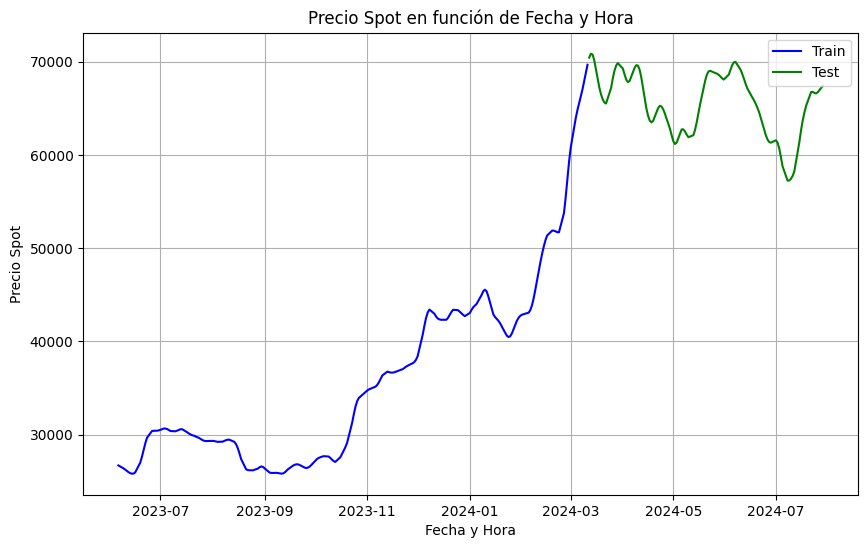

In [ ]:
full = data.copy()
cols_to_convert = ["target", "open", "max", "min", "var", "MACD", "Signal_Line"] + SMA_cols + EMA_cols + Bollinger_cols + ATR_cols + CCI_cols + ROC_cols + Williams_cols + Stochastic_cols + exog_ts + VIX_cols + lag_cols + target_smoothed_cols + RSI_cols
full[cols_to_convert] = full[cols_to_convert].apply(pd.to_numeric, errors='coerce')
full = full.ffill().bfill()

data = full[:-test_len]
test = full[-test_len:]
data = data.reset_index(drop=True)
data = data.dropna()


plt.figure(figsize=(10, 6))
plt.plot(data["Date"][-200:], data["target"][-200:], color="blue", label="Train")
plt.plot(test["Date"][-200:], test["target"][-200:], color="green", label="Test")

plt.xlabel("Fecha y Hora")
plt.ylabel("Precio Spot")
plt.title("Precio Spot en función de Fecha y Hora")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
data

,Date,exog_target,open,max,min,var,exog_Nasdaq,exog_IBEX35,exog_EUStoxx50,exog_DowJones,...,bullish_atr,bearish_atr,bullish_trend,bearish_trend,group,month,day_of_year,weekday,is_holiday,time_idx
0,2016-01-01,434.0,430.0,434.1,423.1,-0.70,4497.86,9313.2,3164.76,17148.94,...,0,0,0,0,1,January,1,Friday,No,0
1,2016-01-04,433.3,430.7,434.1,423.1,-0.70,4497.86,9313.2,3164.76,17148.94,...,0,0,0,0,1,January,4,Monday,No,3
2,2016-01-05,431.2,433.3,435.3,428.6,0.61,4497.86,9313.2,3164.76,17148.94,...,0,0,0,0,1,January,5,Tuesday,No,4
3,2016-01-06,430.8,431.2,435.3,428.9,-0.49,4484.18,9335.2,3178.01,17158.66,...,0,0,0,0,1,January,6,Wednesday,No,5
4,2016-01-07,457.0,430.8,432.1,425.0,-0.09,4443.98,9197.4,3139.32,16906.51,...,0,0,0,0,1,January,7,Thursday,No,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,2024-03-05,63792.6,68273.1,68495.1,62746.8,8.13,18226.48,10069.8,4912.92,38989.83,...,1,0,1,0,1,March,65,Tuesday,No,2986
2133,2024-03-06,66080.4,63794.7,69063.1,60138.2,-6.56,17897.87,10117.1,4893.07,38585.19,...,1,0,1,0,1,March,66,Wednesday,No,2987
2134,2024-03-07,66855.3,66074.6,67604.9,62848.7,3.59,18017.57,10197.2,4915.49,38661.05,...,1,0,1,0,1,March,67,Thursday,No,2988
2135,2024-03-08,68172.0,66854.4,67985.5,65602.6,1.17,18297.99,10319.6,4974.22,38791.35,...,1,0,1,0,1,March,68,Friday,No,2989


## DF FINL

<!-- ## TimeSeriesDataset -->

In [ ]:
max_prediction_length = pred_len
max_encoder_length = n_prev_len 
# Ajusta training_cutoff para reservar un rango más amplio para la validación
# validation_size = 50  # ajusta según el tamaño deseado para el conjunto de validación
training_cutoff = data["time_idx"].max() - max_prediction_length #- validation_size

train = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="target",
    group_ids=[group],
    min_encoder_length=max_encoder_length,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    # min_prediction_length=24,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=["month", "weekday", "day_of_year", "is_holiday"],  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["Date", "time_idx", 'FEDFUNDS'] + AAII_cols + PIB_cols,
                                        
    time_varying_unknown_categoricals=  bullish_cols +  bearish_cols,
    time_varying_unknown_reals=[
        "target",
        "open",
        "max",
        "min",
        # "vol",
        "var",
        "MACD",
        "Signal_Line",
    ]     + 
    lag_cols + 
    SMA_cols +
    EMA_cols +
    RSI_cols +
    Bollinger_cols +
    ATR_cols +
    CCI_cols +
    ROC_cols +
    Stochastic_cols +
    Williams_cols +
    VIX_cols +
    exog_ts +
    target_smoothed_cols
    ,
    # lags={"target": list(range(1, 5))},
    # target_normalizer=GroupNormalizer("standard", groups=[group], transformation="softplus"),
    # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    allow_missing_timesteps=True,
    # add_encoder_length=True,
    categorical_encoders={
        "month": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        "weekday": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
        "day_of_year": pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True),
    },
)

validation = TimeSeriesDataSet.from_dataset(train,  data, predict=True, stop_randomization=True)
# test = TimeSeriesDataSet.from_dataset(training, test_data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = train.to_dataloader(
    train=True, batch_size=batch_size, num_workers=7, persistent_workers=True
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=7, persistent_workers=True
)
# test_dataloader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=11, persistent_workers=True)

In [ ]:
validation

TimeSeriesDataSet[length=1](
	time_idx='time_idx',
	target='target',
	group_ids=['group'],
	weight=None,
	max_encoder_length=50,
	min_encoder_length=50,
	min_prediction_idx=0,
	min_prediction_length=25,
	max_prediction_length=25,
	static_categoricals=[],
	static_reals=['target_center', 'target_scale'],
	time_varying_known_categoricals=['month', 'weekday', 'day_of_year', 'is_holiday'],
	time_varying_known_reals=['Date', 'time_idx', 'FEDFUNDS', 'AAII_Bullish', 'AAII_Neutral', 'AAII_Bearish', 'PIB_USA', 'PIB_CHN', 'PIB_DEU', 'PIB_JPN', 'PIB_IND', 'PIB_BRA', 'PIB_CAN', 'relative_time_idx'],
	time_varying_unknown_categoricals=['bullish_sma_50_200', 'bullish_rsi', 'bullish_bollinger', 'bullish_macd', 'bullish_atr', 'bullish_trend', 'bearish_sma_50_200', 'bearish_rsi', 'bearish_bollinger', 'bearish_macd', 'bearish_atr', 'bearish_trend'],
	time_varying_unknown_reals=['target', 'open', 'max', 'min', 'var', 'MACD', 'Signal_Line', 'target_lag1', 'target_lag2', 'target_lag3', 'target_lag4', 'targe

<!-- 
# LEARNIG RATE FINDER -->

<!-- En primer lugar realizamos un estudio para hallar de forma aproximada el valor optimo de tasa de aprendizaje.  No es recomendable al 100% usar el valor sugerido directamente pues a veces no encuentra el mejor, sin embargo si que da un muy buen punto de partida por donde empezar a probar. Para ello usamos un modelo TFT cualquiera basico. -->

In [ ]:
if lr_finder:
    res = get_best_lr(train, train_dataloader, val_dataloader, **tft_params)


<!-- # MODELLING -->

<!-- ## TRAIN MODEL -->

In [ ]:
if not grid_search:
    # tft_params["learning_rate"] = 0.01
    tft, val_loss = tft_trainer(train, train_dataloader, val_dataloader, max_epochs=epochs, **tft_params)

<!-- ### EVAL MODEL -->

In [ ]:
if not grid_search:
    preds = tft_predict(tft, val_dataloader)


<!-- ## GRID SEARCH -->

In [ ]:
if grid_search == "random":
    # Suprime todos los warnings
    warnings.filterwarnings("ignore")

    # Llamada a la función de búsqueda aleatoria
    best_model, best_params, best_val_loss = random_hyperparameter_search(
        data,
        train,
        train_dataloader,
        val_dataloader,
        test,
        param_grid,
        n_iterations=50,
        max_epochs=epochs,
        save_dir=f'./plots/{target_file}_gauss_multiexog_-{n_prev_len}d-{date_start.replace("-","")}-{date_end.replace("-","")}',
        csv_file=f"./results/{target_file}_gauss_multiexog-{n_prev_len}d-{date_start}-{date_end}.csv",
    )


 -------------------------------------------------------- 
 Probando combinación aleatoria 1/50: {'gradient_clip_val': 0.03, 'hidden_size': 32, 'dropout': 0.3, 'hidden_continuous_size': 64, 'attention_head_size': 8, 'learning_rate': 0.03, 'loss': MAE(), 'test_len': 100, 'pred_len': 25, 'n_prev_len': 50}


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 99: 100%|██████████| 32/32 [00:34<00:00,  0.94it/s, v_num=6, train_loss_step=578.0, val_loss=1.53e+4, train_loss_epoch=504.0]    

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 32/32 [00:34<00:00,  0.92it/s, v_num=6, train_loss_step=578.0, val_loss=1.53e+4, train_loss_epoch=504.0]
Number of parameters in network: 697.7k
Training time: 48m 54s
Nueva mejor combinación encontrada: {'gradient_clip_val': 0.03, 'hidden_size': 32, 'dropout': 0.3, 'hidden_continuous_size': 64, 'attention_head_size': 8, 'learning_rate': 0.03, 'loss': MAE(), 'test_len': 100, 'pred_len': 25, 'n_prev_len': 50} con pérdida 15326.7666


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



 -------------------------------------------------------- 
 Probando combinación aleatoria 2/50: {'gradient_clip_val': 0.05, 'hidden_size': 32, 'dropout': 0.1, 'hidden_continuous_size': 64, 'attention_head_size': 4, 'learning_rate': 0.01, 'loss': MAE(), 'test_len': 100, 'pred_len': 25, 'n_prev_len': 50}
Epoch 99: 100%|██████████| 32/32 [00:44<00:00,  0.72it/s, v_num=11, train_loss_step=620.0, val_loss=1.41e+4, train_loss_epoch=617.0]    

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 32/32 [00:44<00:00,  0.71it/s, v_num=11, train_loss_step=620.0, val_loss=1.41e+4, train_loss_epoch=617.0]
Number of parameters in network: 697.9k
Training time: 66m 19s
Nueva mejor combinación encontrada: {'gradient_clip_val': 0.05, 'hidden_size': 32, 'dropout': 0.1, 'hidden_continuous_size': 64, 'attention_head_size': 4, 'learning_rate': 0.01, 'loss': MAE(), 'test_len': 100, 'pred_len': 25, 'n_prev_len': 50} con pérdida 14126.9277


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



 -------------------------------------------------------- 
 Probando combinación aleatoria 3/50: {'gradient_clip_val': 0.05, 'hidden_size': 16, 'dropout': 0.1, 'hidden_continuous_size': 128, 'attention_head_size': 4, 'learning_rate': 0.01, 'loss': MAE(), 'test_len': 100, 'pred_len': 25, 'n_prev_len': 50}
Epoch 99: 100%|██████████| 32/32 [00:49<00:00,  0.64it/s, v_num=16, train_loss_step=734.0, val_loss=1.5e+4, train_loss_epoch=691.0]     

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 32/32 [00:50<00:00,  0.64it/s, v_num=16, train_loss_step=734.0, val_loss=1.5e+4, train_loss_epoch=691.0]
Number of parameters in network: 461.9k
Training time: 77m 22s


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



 -------------------------------------------------------- 
 Probando combinación aleatoria 4/50: {'gradient_clip_val': 0.05, 'hidden_size': 8, 'dropout': 0.3, 'hidden_continuous_size': 64, 'attention_head_size': 16, 'learning_rate': 0.005, 'loss': MAE(), 'test_len': 100, 'pred_len': 25, 'n_prev_len': 50}
Epoch 99: 100%|██████████| 32/32 [00:49<00:00,  0.65it/s, v_num=21, train_loss_step=1.64e+3, val_loss=1.1e+4, train_loss_epoch=1.19e+3] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 32/32 [00:49<00:00,  0.64it/s, v_num=21, train_loss_step=1.64e+3, val_loss=1.1e+4, train_loss_epoch=1.19e+3]
Number of parameters in network: 126.5k
Training time: 78m 26s
Nueva mejor combinación encontrada: {'gradient_clip_val': 0.05, 'hidden_size': 8, 'dropout': 0.3, 'hidden_continuous_size': 64, 'attention_head_size': 16, 'learning_rate': 0.005, 'loss': MAE(), 'test_len': 100, 'pred_len': 25, 'n_prev_len': 50} con pérdida 10985.5596


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



 -------------------------------------------------------- 
 Probando combinación aleatoria 5/50: {'gradient_clip_val': 0.03, 'hidden_size': 32, 'dropout': 0.2, 'hidden_continuous_size': 16, 'attention_head_size': 16, 'learning_rate': 0.03, 'loss': MAE(), 'test_len': 100, 'pred_len': 25, 'n_prev_len': 50}
Epoch 99: 100%|██████████| 32/32 [01:05<00:00,  0.49it/s, v_num=26, train_loss_step=457.0, val_loss=1.48e+4, train_loss_epoch=499.0]    

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 32/32 [01:05<00:00,  0.49it/s, v_num=26, train_loss_step=457.0, val_loss=1.48e+4, train_loss_epoch=499.0]
Number of parameters in network: 270.3k
Training time: 101m 56s


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



 -------------------------------------------------------- 
 Probando combinación aleatoria 6/50: {'gradient_clip_val': 0.05, 'hidden_size': 8, 'dropout': 0.3, 'hidden_continuous_size': 128, 'attention_head_size': 16, 'learning_rate': 0.03, 'loss': MAE(), 'test_len': 100, 'pred_len': 25, 'n_prev_len': 50}
Epoch 12:  44%|████▍     | 14/32 [00:24<00:31,  0.57it/s, v_num=31, train_loss_step=1.93e+3, val_loss=9.2e+3, train_loss_epoch=1.42e+3] Number of parameters in network: 220.8k
Training time: 12m 52s
Nueva mejor combinación encontrada: {'gradient_clip_val': 0.05, 'hidden_size': 8, 'dropout': 0.3, 'hidden_continuous_size': 128, 'attention_head_size': 16, 'learning_rate': 0.03, 'loss': MAE(), 'test_len': 100, 'pred_len': 25, 'n_prev_len': 50} con pérdida 9199.2031


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



 -------------------------------------------------------- 
 Probando combinación aleatoria 7/50: {'gradient_clip_val': 0.03, 'hidden_size': 16, 'dropout': 0.1, 'hidden_continuous_size': 16, 'attention_head_size': 4, 'learning_rate': 0.01, 'loss': MAE(), 'test_len': 100, 'pred_len': 25, 'n_prev_len': 50}


RuntimeError: Only Tensors created explicitly by the user (graph leaves) support the deepcopy protocol at the moment

In [ ]:
if grid_search == "exhaustive":
    
    # Suprime todos los warnings 

    
    warnings.filterwarnings("ignore")
    
    # Llamada a la función de búsqueda de hiperparámetros
    best_model, best_params, best_val_loss = exhaustive_hyperparameter_search(
        data, train, train_dataloader, val_dataloader, test, param_grid, max_epochs=1
    )